<a href="https://colab.research.google.com/github/somwrks/AI-Solar-Panel/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self Rotatory Solar Panel

This Project utilizes various vision models to train on planet sun labelled datasets and perform validation checks to determine which model performs the best and converts the best model to tinyML Model to make it usable by microcontroller

## Installing Dependencies

In [3]:
%pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
%pip install inference tensorflow[and-cuda] suncalc tensorflow-datasets roboflow ultralytics torch torchvision matplotlib tqdm


## Importing Libraries

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from ultralytics import YOLO
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
from inference import get_model
import supervision as sv
import cv2
import numpy as np
import time
from datetime import datetime, timezone
from suncalc import get_position
import math
from datetime import datetime, timezone, timedelta
import geocoder
from tensorflow.keras import mixed_precision
import yaml
import os
from PIL import Image
from roboflow import Roboflow
from inference import get_model
import supervision as sv
import locale
import cv2
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from google.colab import userdata

## Setting up Environment

In [6]:
api_key = userdata.get('ROBOFLOW_API_KEY')

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['NO_ALBUMENTATIONS_UPDATE '] = '1'


In [9]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices())


TensorFlow version: 2.17.1
GPU Available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# List available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if len(physical_devices) > 0:
# Enable memory growth for all GPUs
  for gpu in physical_devices:
      tf.config.experimental.set_memory_growth(gpu, True)

  # Use all available GPUs
  tf.config.set_visible_devices(physical_devices, 'GPU')

  # Enable XLA (Accelerated Linear Algebra) optimization
  tf.config.optimizer.set_jit(True)

  tf.config.set_visible_devices(physical_devices[0], 'GPU')

  # Enable mixed precision training

  policy = mixed_precision.Policy('mixed_float16')
  mixed_precision.set_global_policy(policy)

  print("GPU optimization settings applied successfully")
else:
    print("No GPU available. Running on CPU.")

Num GPUs Available:  1
GPU optimization settings applied successfully


## Loading Datasets

We're implementing various datasets from roboflow and our own custom images dataset for maximum training data

In [11]:

# Download both datasets
rf = Roboflow(api_key=api_key)

# Dataset 1

project1 = rf.workspace("yassine-pzpt7").project("sun-tracking-photovoltaic-panel")
version1 = project1.version(2)
dataset1 = version1.download("yolov8")

# Dataset 2
project2 = rf.workspace("1009727588-qq-com").project("sun-nxvfz")
dataset2 = project2.version(2).download("yolov8")

# Dataset 3
project3 = rf.workspace("rik-tjduw").project("sun-tracking-555mn")
version3 = project3.version(4)
dataset3 = version3.download("yolov8")

# Dataset 4
project4 = rf.workspace("stardetect").project("solar-re1fe")
version4 = project4.version(1)
dataset4 = version4.download("yolov8")

# Dataset 5
project5 = rf.workspace("fruitdetection-ulcz9").project("sun_detection-hl04q")
version5 = project5.version(1)
dataset5 = version5.download("yolov8")

# Prepare dataset paths
dataset1_path = dataset1.location
dataset2_path = dataset2.location
dataset3_path = dataset3.location
dataset4_path = dataset4.location
dataset5_path = dataset5.location

def resize_images(directory, target_resolution=(640, 640)):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        img_resized = img.resize(target_resolution, Image.LANCZOS)
                        img_resized.save(image_path)
                except Exception as e:
                    print(f"Error resizing image {image_path}: {e}")

# Function to count images in a directory
def count_images(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    return len([f for f in os.listdir(directory) if f.lower().endswith(image_extensions)])

# Function to combine datasets

def combine_datasets(*dataset_paths, combined_path):
    for split in ['train', 'valid', 'test']:
        os.makedirs(os.path.join(combined_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(combined_path, split, 'labels'), exist_ok=True)

        for dataset_path in dataset_paths:
            images_src = os.path.join(dataset_path, split, 'images')
            labels_src = os.path.join(dataset_path, split, 'labels')

            images_dst = os.path.join(combined_path, split, 'images')
            labels_dst = os.path.join(combined_path, split, 'labels')

            if os.path.exists(images_src):
                for file in os.listdir(images_src):
                    shutil.copy2(os.path.join(images_src, file), images_dst)
            if os.path.exists(labels_src):
                for file in os.listdir(labels_src):
                    shutil.copy2(os.path.join(labels_src, file), labels_dst)


# Combine datasets
combined_path = './combined_dataset'
combine_datasets(dataset1_path, dataset2_path, dataset3_path,dataset4_path, dataset5_path, combined_path=combined_path)

# Resize images in the combined dataset
for split in ['train', 'valid', 'test']:
    images_dir = os.path.join(combined_path, split, 'images')
    resize_images(images_dir)

print("Images resized to target resolution.")


# Count images in each dataset
train_count = len(os.listdir(os.path.join(combined_path, 'train', 'images')))
valid_count = len(os.listdir(os.path.join(combined_path, 'valid', 'images')))
test_count = len(os.listdir(os.path.join(combined_path, 'test', 'images')))
num_classes = len(set([f.split('_')[0] for f in os.listdir(os.path.join(combined_path, 'train', 'labels'))]))

print(f"Number of images in training set: {train_count}")
print(f"Number of images in validation set: {valid_count}")
print(f"Number of images in test set: {test_count}")
print(f"Total number of images: {train_count + valid_count + test_count}")

# Create YAML file for YOLOv5
yaml_content = {
    'train': os.path.join(combined_path, 'train'),
    'val': os.path.join(combined_path, 'valid'),
    'test': os.path.join(combined_path, 'test'),
    'nc': len(os.listdir(os.path.join(combined_path, 'train', 'labels'))),
    'names': [f'class_{i}' for i in range(len(os.listdir(os.path.join(combined_path, 'train', 'labels'))))],
    'image_counts': {
        'train': train_count,
        'val': valid_count,
        'test': test_count
    }
}


yaml_content = {
    'train': os.path.join(combined_path, 'train'),
    'val': os.path.join(combined_path, 'valid'),
    'test': os.path.join(combined_path, 'test'),
    'nc': num_classes,
    'names': [f'class_{i}' for i in range(num_classes)],
}

yaml_path = os.path.join(combined_path, 'dataset.yaml')
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(yaml_content, yaml_file, default_flow_style=False)

print(f"Dataset YAML file created at: {yaml_path}")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Sun-tracking-photovoltaic-panel-2 in yolov8:: 100%|██████████| 404/404 [00:00<00:00, 8988.10it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to sun-2 in yolov8:: 100%|██████████| 342/342 [00:00<00:00, 8958.27it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Sun-Tracking-4 in yolov8:: 100%|██████████| 1858/1858 [00:00<00:00, 7620.15it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Solar-1 in yolov8:: 100%|██████████| 5380/5380 [00:00<00:00, 8549.63it/s]

loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to Sun_Detection-1 in yolov8:: 100%|██████████| 1419/1419 [00:00<00:00, 8011.08it/s]


Images resized to target resolution.
Number of images in training set: 3597
Number of images in validation set: 633
Number of images in test set: 443
Total number of images: 4673
Dataset YAML file created at: ./combined_dataset/dataset.yaml


## Setting Up Models


### 2. YoloV5 (LibRT)

In [12]:
locale.getpreferredencoding = lambda: "UTF-8"


Loading model from drive

In [13]:
yolo_model = YOLO('drive/MyDrive/sun_tracker_model.pt')
# yolo_model = YOLO('yolov8l.pt')


In [24]:
full_yaml_path = os.path.abspath(yaml_path)
yolo_results = yolo_model.train(
    data=full_yaml_path,
    epochs=500,
    imgsz=640,
    lr0=0.001,
    lrf=0.0001,
    batch=-1,
    device=[0],
    augment=True,
    cos_lr=True,
    amp=True,
    resume=True,
    patience=300,
    mixup=0.2,
    mosaic=1.0,
    close_mosaic=10
)



Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/combined_dataset/dataset.yaml, epochs=500, time=None, patience=300, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning /content/combined_dataset/train/labels.cache... 3597 images, 218 backgrounds, 0 corrupt: 100%|██████████| 3597/3597 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 579, len(boxes) = 3384. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA L4) 22.17G total, 1.91G reserved, 1.56G allocated, 18.70G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


    43895064       166.9         3.678          37.1         21.04        (1, 3, 640, 640)                    list
    43895064       333.8         4.255         38.03         24.97        (2, 3, 640, 640)                    list
    43895064       667.5         5.478         48.17          33.7        (4, 3, 640, 640)                    list
    43895064        1335         7.841         63.77         75.39        (8, 3, 640, 640)                    list
    43895064        2670        12.562         154.8           170       (16, 3, 640, 640)                    list
    43895064        5340        22.398         350.9         370.8       (32, 3, 640, 640)                    list
CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 2.88 MiB is free. Process 69173 has 22.15 GiB memory in use. Of the allocated memory 21.71 GiB is allocated by PyTorch, and 173.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is

train: Scanning /content/combined_dataset/train/labels.cache... 3597 images, 218 backgrounds, 0 corrupt: 100%|██████████| 3597/3597 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 579, len(boxes) = 3384. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/combined_dataset/valid/labels.cache... 633 images, 19 backgrounds, 0 corrupt: 100%|██████████| 633/633 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      11.9G      1.637      4.064      1.795         15        640: 100%|██████████| 225/225 [01:59<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.708        0.7      0.726      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      11.7G      1.447      2.557      1.564         26        640: 100%|██████████| 225/225 [01:56<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.632      0.712      0.689      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      11.9G      1.571      2.548      1.661         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

                   all        633        614      0.531      0.589      0.556       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      11.9G      1.672       2.28      1.697         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.745       0.47      0.575      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      11.9G      1.626      1.896       1.68         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.607      0.731       0.73      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      11.8G      1.589      1.722      1.658         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.691      0.758      0.781      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      11.7G      1.545      1.612      1.621         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

                   all        633        614      0.651      0.725      0.742       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      11.9G      1.551      1.549      1.662         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.658      0.745      0.763      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      11.9G      1.521      1.503      1.631         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.709      0.759       0.77      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      11.9G      1.495      1.435      1.615         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

                   all        633        614      0.651      0.723      0.708      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      11.7G      1.447       1.38      1.582         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.735      0.747      0.804      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      11.9G      1.441      1.336      1.558         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.716      0.653      0.705       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      11.9G      1.409      1.313      1.537         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.726      0.793      0.813      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      11.8G      1.422      1.291      1.547         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614       0.72      0.758      0.815      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      11.7G      1.409      1.288      1.555         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.714      0.814      0.798      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      11.9G       1.37      1.235       1.52         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.718      0.798       0.81      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      11.9G      1.336      1.214      1.491         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.705      0.796      0.827       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      11.9G      1.328      1.192      1.497         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.763      0.775      0.831       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      11.7G      1.341      1.213      1.508         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.739      0.814      0.812      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      11.9G      1.351      1.195      1.515         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.733      0.821      0.824      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      11.9G      1.307      1.128      1.501         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.761      0.813      0.842      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      11.8G      1.322       1.14      1.504         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.78      0.855      0.872      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      11.7G      1.327      1.133      1.517         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.723        0.8      0.818      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      11.9G      1.293      1.112      1.496         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614       0.72      0.798      0.808      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      11.9G      1.305      1.114      1.493         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.711      0.854      0.835      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      11.8G      1.265      1.081      1.465         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.745      0.881      0.869      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      11.7G       1.26       1.07      1.466         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.767      0.852       0.83      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      11.9G      1.286      1.076      1.481         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.728      0.835      0.828      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      11.9G      1.271       1.07      1.465         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.751      0.839      0.859      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      11.8G      1.247      1.042       1.45         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.728      0.883      0.836       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      11.7G      1.255      1.061      1.469         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.772      0.831       0.85      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      11.9G      1.252      1.047      1.456         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614       0.76      0.848      0.827      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      11.8G      1.241      1.024      1.457         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614       0.78      0.873      0.864      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      11.8G      1.241      1.022      1.458         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.771       0.87      0.858      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      11.7G      1.219      1.005      1.433         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.775      0.874       0.87      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      11.9G      1.229      1.026      1.432         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.801      0.862      0.871      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      11.9G      1.219      1.007      1.431         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.751      0.888      0.862       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      11.8G      1.218      1.011      1.431         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.801      0.871      0.875      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      11.7G      1.194      0.983      1.419         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.745      0.847      0.826      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      11.9G      1.212     0.9932      1.433         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.801      0.879      0.881      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      11.9G       1.19     0.9807      1.413         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.812      0.878      0.905      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      11.8G      1.187     0.9776      1.415         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.797      0.872      0.848      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      11.7G      1.201     0.9711      1.433         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.794      0.891      0.861      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      11.9G      1.177     0.9564      1.412         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.817      0.871      0.886      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      11.9G      1.176     0.9612      1.413         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.783       0.89      0.876      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      11.8G      1.169     0.9411      1.408         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.805      0.863      0.877      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      11.7G      1.172     0.9597      1.402         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.817      0.888      0.894      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      11.9G      1.159     0.9387      1.399         34        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.812      0.894      0.902      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      11.9G      1.167     0.9212      1.396         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.772      0.873      0.858      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      11.9G      1.164     0.9432      1.399         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.813      0.889      0.894      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      11.7G      1.163     0.9298      1.398         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.782        0.9       0.88      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      11.9G       1.15     0.9168      1.389         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.757      0.894      0.868      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      11.9G       1.17     0.9177        1.4         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.807      0.856      0.883      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      11.8G      1.156     0.9009      1.396         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.853      0.886      0.897      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      11.7G      1.139     0.9113      1.377         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.854      0.902      0.909      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      11.9G      1.144      0.896      1.379         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.852       0.89      0.895      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      11.9G      1.135     0.9027      1.372         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.858      0.883      0.911      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      11.8G      1.139     0.9081       1.38         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.814       0.91        0.9      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      11.7G      1.134     0.8951      1.367         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.861      0.916      0.917      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      11.9G      1.121      0.892      1.365         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.835      0.877      0.895      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      11.9G      1.107     0.8577      1.348         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.808      0.878      0.871      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      11.9G       1.11     0.8741      1.351         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.828      0.902      0.895      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      11.7G      1.139     0.9027      1.372         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.802      0.904      0.894       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      11.9G      1.136     0.8966      1.377         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.843       0.89      0.905      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      11.9G      1.121     0.9029      1.365         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.847      0.881      0.891      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      11.8G      1.109     0.8689      1.357         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.857      0.903      0.917       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      11.7G      1.101     0.8683      1.349         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.842      0.904      0.913      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      11.9G        1.1     0.8448      1.345         41        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.782      0.893      0.877      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      11.9G      1.096     0.8475      1.338         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.844      0.893      0.917      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      11.8G      1.114     0.8626      1.361         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.827      0.894      0.906      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      11.7G      1.098     0.8466      1.348         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.833      0.894      0.912      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      11.9G      1.087     0.8527      1.338         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614       0.86      0.902      0.926      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      11.9G      1.097     0.8505      1.354         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.815      0.911      0.898      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      11.8G      1.075     0.8284      1.328         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.836      0.895      0.898      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      11.7G      1.092     0.8564      1.354         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.869      0.911       0.92      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      11.9G      1.094     0.8378      1.348         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.888      0.919      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      11.9G       1.09     0.8414      1.343         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.865      0.913      0.915      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      11.8G      1.078     0.8288      1.336         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]

                   all        633        614      0.865      0.898      0.918      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      11.7G      1.066     0.8017      1.333         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.848      0.925      0.922       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      11.9G      1.085     0.8425      1.338         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.843      0.897      0.907        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      11.9G      1.068     0.8112       1.33         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.818      0.918      0.895      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      11.9G      1.068     0.8053      1.339         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.846      0.909      0.915      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      11.7G       1.08     0.8288      1.345         32        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.842      0.902      0.923      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      11.9G      1.056     0.7878      1.309         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.839      0.913      0.909      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      11.9G      1.055     0.8057      1.324         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.858      0.902      0.928      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      11.8G      1.049     0.8095      1.323         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.861      0.912      0.928      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      11.7G      1.058     0.7801      1.313         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.864        0.9      0.919      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      11.9G      1.048     0.7878      1.317         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.87      0.916      0.928      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      11.9G      1.054     0.8077      1.317         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.863      0.889      0.913      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      11.8G       1.05     0.7933      1.321         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.855      0.915       0.92      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      11.7G      1.038     0.7724      1.306         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.815      0.913      0.898      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      11.9G      1.021     0.7682      1.292         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.843      0.894      0.907      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      11.9G       1.06     0.8099      1.332         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.837      0.914      0.904      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      11.8G      1.055     0.7823       1.31         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.878      0.911      0.933      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      11.7G      1.063     0.8039      1.324         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.914      0.932      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      11.9G       1.04     0.7778      1.316         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.867      0.912      0.928      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      11.9G      1.038     0.7785      1.308         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872        0.9      0.924      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      11.8G       1.03     0.7677      1.302         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.858      0.913      0.924      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      11.7G       1.03     0.7662      1.305         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.866      0.922      0.924       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      11.9G      1.029     0.7774      1.309         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.873      0.921       0.93      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      11.9G      1.031      0.753      1.316         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.845      0.905      0.911      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      11.8G       1.04      0.777      1.317         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.885      0.912      0.929      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      11.7G      1.039     0.7712      1.309         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.841      0.922      0.906      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      11.9G      1.036     0.7647      1.305         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.871      0.913      0.915      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      11.9G      1.036     0.7483       1.31         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.864      0.919      0.921      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      11.8G      1.041     0.7809      1.315         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.865      0.928      0.926      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      11.7G      1.022     0.7575      1.299         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.869       0.91      0.923      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      11.9G      1.024     0.7664      1.299         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.889       0.93      0.941      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      11.9G      1.021     0.7529      1.301         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.864      0.937       0.93      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      11.8G       1.04     0.7689      1.309         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.846      0.915      0.919      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      11.7G      1.008      0.744      1.291         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.853      0.918      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      11.9G     0.9994     0.7264      1.277         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.852      0.928      0.923       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      11.9G     0.9935      0.744      1.282         14        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.878      0.915      0.928       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      11.8G      0.995     0.7325      1.281         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.877      0.923      0.931       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      11.7G      0.995     0.7413      1.288         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.936       0.93      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      11.9G     0.9941     0.7391      1.276         37        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.885       0.92      0.934      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      11.9G     0.9744     0.7279      1.263         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.851      0.919      0.921      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      11.8G      1.005      0.723      1.281         32        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.861      0.913       0.92      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      11.7G     0.9884      0.729      1.278         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.869      0.918      0.924      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      11.9G     0.9999     0.7389      1.295         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.87      0.911      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      11.8G     0.9893     0.7156      1.276         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.873      0.905      0.927      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      11.8G     0.9886     0.7267       1.28         14        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.866      0.906      0.923      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      11.7G      1.004     0.7416      1.282         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.85      0.927      0.915      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      11.9G      1.003     0.7408      1.295         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.851      0.931      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      11.9G     0.9852     0.7116      1.269         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.878      0.921      0.921      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      11.8G     0.9849      0.738      1.274         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.876      0.909      0.923      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      11.7G     0.9893     0.7119      1.282         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.869      0.906      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      11.9G     0.9736     0.7132      1.273         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.851      0.933      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      11.9G     0.9876     0.7224      1.277         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.853      0.936      0.924      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      11.8G     0.9522     0.6918      1.256         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.873      0.932      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      11.7G     0.9761     0.6997      1.256         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.875      0.926      0.939      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      11.9G     0.9663     0.6932      1.251         32        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.853      0.925      0.922      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500      11.8G     0.9718     0.7036      1.261         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.851      0.931      0.919      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      11.8G     0.9814     0.7236      1.264         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.854      0.919      0.919      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      11.7G     0.9519     0.6882      1.248         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.851      0.941      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      11.9G     0.9669     0.7019      1.266         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.862      0.916      0.927      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      11.9G      0.962     0.6913      1.253         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.853      0.942      0.928      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      11.9G     0.9759      0.712       1.27         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.864      0.935      0.935      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      11.7G     0.9528     0.7015      1.267         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.873      0.929      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      11.9G     0.9619     0.6978      1.266         14        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.85      0.928      0.924      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      11.9G     0.9655     0.7003      1.269         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.874      0.933      0.937      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      11.9G     0.9647     0.7023      1.265         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.863      0.941      0.935      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      11.7G     0.9403     0.6692      1.247         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.873      0.942      0.935      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      11.9G     0.9522     0.6967      1.248         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.856      0.923      0.927      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      11.9G     0.9471     0.6953      1.243         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.855      0.919      0.928      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      11.8G      0.959     0.6932      1.253         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.863      0.937      0.928      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      11.7G     0.9682     0.6938      1.257         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.867      0.936      0.934      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      11.9G     0.9653     0.7029      1.259         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.869      0.926      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      11.9G     0.9334     0.6765       1.24         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.856      0.927      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      11.8G     0.9627     0.6881      1.266         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.873      0.933      0.941      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      11.7G     0.9334     0.6767      1.234         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.871       0.93      0.934      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      11.9G     0.9635     0.6826      1.258         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.883      0.929      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      11.9G     0.9315     0.6737      1.237         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.873      0.927      0.926      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      11.8G     0.9404     0.6824      1.241         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.931      0.937      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      11.7G     0.9314     0.6671      1.239         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.885      0.926      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      11.9G      0.929     0.6844      1.231         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.878      0.926      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      11.9G     0.9595     0.6719       1.25         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.875       0.93      0.937      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      11.9G     0.9239     0.6696      1.232         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.874      0.906      0.933      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      11.7G     0.9245     0.6747      1.232         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.885      0.921      0.938      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      11.9G     0.9436      0.676      1.243         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.878      0.923      0.937      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      11.9G     0.9528     0.6861      1.254         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.926      0.942      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      11.8G     0.9127     0.6645      1.216         34        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.872      0.927      0.933      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      11.7G     0.9329      0.655      1.241         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.927      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      11.9G     0.9294     0.6687       1.24         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.877      0.923       0.93      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      11.9G     0.9341     0.6671      1.237         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.877      0.935      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      11.8G     0.9235     0.6575      1.236         34        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879      0.937      0.939      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      11.7G     0.9305     0.6652      1.231         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.861      0.942      0.938      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      11.9G       0.92      0.669      1.231         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.868      0.925       0.93      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      11.9G     0.9434     0.6709      1.246          9        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.856      0.937      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      11.8G     0.9461     0.6639      1.247         12        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.877      0.944      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      11.7G     0.9232      0.664      1.236         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.87      0.934      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      11.9G     0.9326     0.6603      1.239         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879      0.926      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      11.9G      0.912     0.6458      1.223         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.871      0.938      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      11.8G      0.909     0.6463      1.223         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.866      0.926       0.93      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      11.7G     0.9042     0.6419      1.227         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.943      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      11.9G     0.9109     0.6505      1.225         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.883      0.926      0.934      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      11.8G     0.9252     0.6475      1.236         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.875      0.927      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      11.9G     0.9085     0.6464      1.225         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.88      0.927      0.933      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      11.7G     0.9015     0.6381      1.218         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.867      0.938      0.932      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      11.9G     0.9091     0.6416      1.229         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.864      0.927      0.932      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      11.9G     0.8825     0.6111      1.206         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.87      0.933      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      11.8G     0.9175     0.6549      1.233         12        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.931      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      11.7G     0.9086       0.65      1.218         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.875      0.931      0.932       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      11.9G     0.9017     0.6598      1.218         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.929      0.931       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      11.9G     0.8906     0.6249      1.204         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.87       0.94      0.933       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      11.8G     0.9184     0.6428      1.236         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.864      0.936      0.927      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      11.7G     0.8952     0.6208      1.221         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.868      0.937       0.93      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      11.9G      0.891     0.6377      1.212         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.872      0.929      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500      11.9G     0.8888     0.6387      1.213         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.877      0.931      0.938      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      11.8G     0.8824     0.6214      1.207         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.876      0.935      0.938      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      11.7G     0.8688     0.6204      1.202         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.874      0.937      0.941      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      11.9G     0.8699     0.6309      1.201         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882      0.931      0.939      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      11.9G     0.8892     0.6407      1.212         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.878       0.93      0.938      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      11.8G     0.9006     0.6397      1.221         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.876      0.929      0.937      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      11.7G     0.8937     0.6354      1.206         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.876      0.935      0.938      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      11.9G     0.8842     0.6287      1.212         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882      0.929      0.941      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      11.9G     0.8912     0.6322      1.207         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.874      0.947      0.941      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      11.9G     0.8643     0.6092      1.195         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.874      0.943      0.936      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      11.7G     0.8923      0.636      1.211         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879      0.942      0.937      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      11.9G      0.884     0.6179      1.205         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.876      0.947      0.939      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      11.9G     0.8892     0.6218      1.202         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.939      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      11.8G     0.8912     0.6265      1.203         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881      0.946      0.944      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      11.7G     0.8759      0.621      1.198         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.87      0.954      0.938      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      11.9G     0.8684     0.6038      1.191         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.868      0.946       0.94      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      11.9G     0.8722     0.6293      1.203         38        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.87      0.945      0.939      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      11.8G     0.8717     0.6059      1.195         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.871      0.943      0.937      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      11.7G     0.8558     0.6054      1.191         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.868      0.943      0.937      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      11.9G     0.8627     0.6134      1.193         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.87      0.943      0.937      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      11.8G     0.8731     0.6175      1.202         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.874      0.938      0.935      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      11.8G     0.8677      0.612      1.191         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.877      0.939      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      11.7G     0.8625     0.6055      1.187         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.872       0.94      0.934      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      11.9G     0.8636     0.6097      1.195         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.869       0.94      0.935      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      11.9G      0.876     0.6197      1.205         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.937      0.929      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      11.8G     0.8707     0.6178        1.2         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.87       0.93       0.93      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      11.7G     0.8677     0.6048      1.194         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.868      0.934      0.929      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      11.9G     0.8628     0.6169      1.199         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.87      0.933      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      11.9G     0.8659     0.6159       1.19         12        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.869      0.931      0.928      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      11.9G     0.8492     0.6057      1.185         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.87      0.932      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      11.7G     0.8475     0.6088      1.189         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.864       0.94      0.928      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      11.9G     0.8723     0.6207      1.201         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.872      0.937      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      11.9G     0.8551     0.5975      1.189         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.872      0.938      0.929      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      11.9G     0.8486     0.6062      1.181         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.874      0.938      0.933      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      11.7G     0.8395     0.6053      1.178         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.873       0.94      0.934      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500      11.9G     0.8525     0.5968      1.191         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.875      0.941      0.933       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      11.9G     0.8609     0.6101      1.192         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.874      0.939      0.935      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      11.9G     0.8416     0.5954      1.177         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.873       0.94      0.933      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      11.7G     0.8271     0.5856      1.163         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.881      0.932      0.935      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      11.9G     0.8308     0.5847      1.181         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879      0.934      0.935      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      11.9G     0.8376     0.5967      1.182         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.878      0.936      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      11.8G     0.8507     0.5991      1.182         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879      0.936      0.934      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      11.7G     0.8237     0.5779       1.16         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.878      0.942      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      11.9G     0.8429     0.5914      1.166         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.875      0.944      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      11.9G     0.8348     0.5872      1.176         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      11.8G     0.8272     0.5774      1.171         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.876      0.938      0.933      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      11.7G     0.8348     0.5867      1.175         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.873       0.94      0.933      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      11.9G     0.8181     0.5841      1.162         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.869      0.945      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      11.9G     0.8336     0.5865      1.172         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.869      0.944      0.934      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      11.9G     0.8285     0.5791      1.172         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.871      0.944      0.934      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      11.7G     0.8381     0.5943      1.181         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.871      0.944      0.935      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      11.9G     0.8391     0.5952      1.174         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.875      0.945      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      11.9G     0.8207     0.5758      1.161         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.874      0.946      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      11.8G     0.8113     0.5659      1.163         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.876      0.947      0.938      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      11.7G     0.8151     0.5798      1.162         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.877      0.949      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      11.9G     0.8219     0.5795      1.157         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.877      0.948      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      11.9G     0.8072     0.5797      1.153         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.88      0.944      0.937      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      11.8G     0.8068     0.5783      1.157         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881      0.944      0.937      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500      11.7G     0.8072     0.5811      1.159         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.878      0.946      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      11.9G     0.8232     0.5927      1.168         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.873      0.944      0.938      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      11.9G     0.8132     0.5752      1.147         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.874      0.944      0.938       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      11.9G     0.8045     0.5708      1.152         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.877      0.948      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      11.7G     0.8187     0.5808      1.163         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.877      0.948      0.937      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      11.9G     0.8056     0.5733      1.159         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.877      0.945      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      11.9G     0.7996     0.5637      1.151         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.876      0.944      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      11.8G      0.804     0.5635      1.149         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879      0.948      0.938       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      11.7G     0.7986     0.5626      1.147         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.878      0.945      0.938      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      11.9G     0.8012     0.5671      1.148         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879      0.948      0.939      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      11.9G     0.7899     0.5646      1.152         32        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.88      0.949      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      11.8G     0.7791     0.5488       1.14         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882      0.949      0.939      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      11.7G     0.7897     0.5562      1.146         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.95      0.939      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500      11.9G     0.7897      0.552      1.148         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.882      0.951       0.94      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/500      11.9G     0.7868     0.5575      1.143         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.886      0.949       0.94      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/500      11.8G      0.798     0.5651      1.147         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882      0.946      0.939      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/500      11.7G     0.7902     0.5639      1.137         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.883      0.946      0.939      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/500      11.9G     0.7652     0.5369      1.131         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882      0.949      0.938      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/500      11.9G     0.7714     0.5593      1.126         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882      0.948      0.938      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/500      11.9G     0.7812     0.5435      1.138         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882      0.948      0.937      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/500      11.7G     0.7909     0.5535      1.137         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.88      0.946      0.934      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/500      11.9G     0.7848     0.5582      1.142         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.881      0.946      0.934      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500      11.9G     0.7763      0.545      1.139         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883      0.945      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/500      11.8G     0.7589      0.539      1.122         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882      0.947      0.934      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/500      11.7G      0.774     0.5431      1.134         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881      0.949      0.935      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/500      11.9G     0.7859     0.5465       1.14         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.884      0.947      0.936      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/500      11.9G     0.7773     0.5428      1.127         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.884      0.944      0.935      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/500      11.8G     0.7758     0.5371      1.136         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.943      0.935      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/500      11.7G     0.7645     0.5386      1.127         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.886      0.943      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/500      11.9G     0.7606     0.5289      1.125         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.888      0.943      0.938      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      11.9G     0.7739     0.5586      1.136         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.888      0.944      0.939      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500      11.9G     0.7697     0.5417      1.135         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.888      0.942      0.939      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      11.7G     0.7654     0.5454      1.131         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.886      0.942      0.939      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/500      11.9G     0.7585     0.5382      1.117         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.943      0.939      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/500      11.9G     0.7574     0.5339      1.133         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.945      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/500      11.8G     0.7607     0.5414      1.126         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.944      0.938      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      11.7G     0.7713     0.5624      1.126         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.942      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/500      11.9G     0.7476     0.5341      1.116         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.887      0.943      0.938      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/500      11.9G     0.7441     0.5324      1.118         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.941      0.938      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/500      11.8G      0.748     0.5148      1.112         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.888       0.94      0.937      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/500      11.7G     0.7537     0.5426      1.118         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.889       0.94      0.937      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500      11.9G     0.7486     0.5273      1.115         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.888       0.94      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/500      11.8G      0.745     0.5259      1.125         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.941      0.937      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/500      11.8G     0.7667     0.5371      1.128         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.941      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/500      11.7G     0.7213     0.5151      1.099         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.891       0.94      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/500      11.9G     0.7304      0.515      1.105         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.888       0.94      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/500      11.9G     0.7325     0.5212      1.113         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.891       0.94      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500      11.8G      0.745     0.5273      1.118         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.891      0.941      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/500      11.7G     0.7332     0.5283      1.115         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.893      0.941      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/500      11.9G     0.7311     0.5189      1.106         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.894      0.941      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      11.9G     0.7423     0.5356      1.112         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.894      0.941      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/500      11.9G     0.7583     0.5384      1.122         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.939      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/500      11.7G     0.7347     0.5144      1.108         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.891      0.938      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/500      11.9G     0.7168     0.5173      1.105         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.938      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/500      11.9G     0.7252     0.5176      1.102         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.939      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/500      11.8G     0.7163     0.5103      1.096         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.939      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/500      11.7G     0.7372     0.5204      1.116         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.886      0.942      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/500      11.9G     0.7258      0.523      1.102         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885       0.94      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/500      11.9G     0.7247     0.5233      1.108         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.941      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/500      11.8G     0.7313     0.5256      1.101         37        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.885      0.941      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/500      11.7G     0.7294      0.524      1.098         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.885      0.941      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/500      11.9G     0.7157     0.5087      1.094         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.888      0.945      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/500      11.9G      0.709     0.5127      1.094         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.888      0.945      0.936      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/500      11.8G       0.71     0.5033      1.097         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.945      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/500      11.7G     0.7177     0.5181      1.101         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.945      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/500      11.9G     0.7066     0.5058      1.085         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.887      0.945      0.936      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/500      11.9G     0.7151     0.5062      1.092         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.887      0.944      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/500      11.8G     0.7126     0.5127      1.096         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.946      0.936      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/500      11.7G      0.706      0.511      1.107         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.947      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/500      11.9G      0.704     0.5063      1.097         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.947      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/500      11.9G     0.7055      0.506      1.095         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.945      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/500      11.9G     0.7209     0.5139      1.103         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.946      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/500      11.7G     0.6978     0.5069       1.09         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.947      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/500      11.9G     0.6988     0.5036      1.085         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.947      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/500      11.9G     0.7005     0.5069      1.086         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.886      0.947      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/500      11.9G     0.7056     0.5063      1.092         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.947      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/500      11.7G     0.7094     0.5102      1.092         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.886      0.946      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/500      11.9G       0.69     0.4958      1.079         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.947      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/500      11.9G     0.6916     0.4989       1.08         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.947      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/500      11.8G     0.6784     0.4804      1.078         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.886      0.947      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/500      11.7G     0.6759     0.4899      1.075         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.887      0.948      0.936      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/500      11.9G     0.7013     0.5009      1.088         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.948      0.936      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/500      11.9G     0.6965     0.5002      1.085         15        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.948      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/500      11.8G     0.6904     0.4986      1.088         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.948      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/500      11.7G      0.676     0.4753       1.08         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.948      0.936      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/500      11.9G     0.6949     0.4951       1.09         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.887      0.948      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/500      11.9G      0.678     0.4856      1.068         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.948      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/500      11.8G     0.6939      0.505      1.074         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.946      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/500      11.7G      0.696      0.506      1.076         14        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.946      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/500      11.9G     0.6837     0.4936      1.072         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/500      11.9G     0.6724     0.4936       1.07         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.945      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/500      11.8G     0.6715     0.4861      1.073         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/500      11.7G      0.673     0.4909      1.058         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.944      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/500      11.9G     0.6775     0.5064      1.067         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/500      11.8G     0.6789     0.4913      1.078         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.943      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/500      11.8G     0.6689     0.4854      1.067         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.944      0.934      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/500      11.7G     0.6714     0.4864      1.064         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.885      0.944      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/500      11.9G     0.6718     0.4822      1.065         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.885      0.944      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/500      11.9G     0.6863     0.4913      1.073         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.884      0.945      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/500      11.8G     0.6762     0.4939      1.073         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.945      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/500      11.7G     0.6766     0.4916      1.076         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.944      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/500      11.9G     0.6692     0.4757      1.071         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.943      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/500      11.9G     0.6703     0.4866      1.069         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883      0.941      0.934      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/500      11.8G     0.6471     0.4668      1.062         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.887       0.94      0.934       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/500      11.7G     0.6684     0.4859      1.065         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.941      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/500      11.9G     0.6495     0.4754      1.056         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.941      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/500      11.9G     0.6534     0.4734      1.062         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.941      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/500      11.8G     0.6637     0.4888      1.064         31        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.888      0.941      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/500      11.7G      0.659     0.4867      1.057         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.942      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/500      11.9G     0.6415     0.4565      1.048         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.942      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/500      11.9G     0.6491     0.4717      1.052         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.942      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/500      11.8G      0.642     0.4638      1.048         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.942      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/500      11.7G     0.6547     0.4763      1.061         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.943      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/500      11.9G     0.6713     0.4865      1.064         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.887      0.943      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/500      11.9G     0.6541     0.4717      1.056         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.943      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/500      11.9G      0.631     0.4619      1.042         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.886      0.943      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/500      11.7G     0.6531     0.4757      1.062         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.943      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/500      11.9G     0.6292     0.4586      1.044         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.888      0.943      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/500      11.9G     0.6405     0.4719      1.052         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.889      0.944      0.937       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/500      11.8G     0.6459     0.4812      1.052         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.887      0.943      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/500      11.7G     0.6353     0.4613      1.047         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.889      0.944      0.938       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/500      11.9G     0.6354     0.4661      1.044         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.945      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/500      11.9G     0.6248      0.463      1.034         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.945      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/500      11.8G     0.6313     0.4665      1.042         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.945      0.939      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/500      11.7G     0.6368     0.4611      1.053         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.945      0.939      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/500      11.9G      0.628     0.4675      1.043         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.889      0.943      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/500      11.9G     0.6329     0.4666      1.042         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/500      11.8G     0.6298     0.4546       1.04         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.889      0.943      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/500      11.7G     0.6243     0.4554      1.049         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.889      0.943      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/500      11.9G     0.6268     0.4542      1.047         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.888      0.942      0.935      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/500      11.9G     0.6271     0.4571      1.046         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.888      0.942      0.935      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/500      11.8G     0.6157     0.4565      1.036         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.889      0.943      0.935      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/500      11.7G     0.6291     0.4633      1.043         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.944      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/500      11.9G     0.6196     0.4519      1.046         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/500      11.9G     0.6303     0.4593      1.042         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/500      11.8G     0.6138     0.4441      1.039         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/500      11.7G      0.624     0.4603      1.048         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.889      0.943      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/500      11.9G     0.6282     0.4638      1.041         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/500      11.9G     0.6139     0.4484      1.035         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.944      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/500      11.8G     0.6234     0.4511      1.036         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/500      11.7G     0.6195     0.4564      1.036         13        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.945      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/500      11.9G     0.6151     0.4522      1.039         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.945      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/500      11.9G     0.5905     0.4439      1.019         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.945      0.936      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/500      11.9G     0.6028     0.4513      1.025         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.945      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/500      11.7G     0.6119     0.4537      1.033         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/500      11.9G      0.607     0.4466      1.029         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614       0.89      0.945      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/500      11.9G     0.6123     0.4468       1.03         17        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.89      0.944      0.936      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/500      11.8G     0.6112     0.4449      1.032         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.888      0.944      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/500      11.7G     0.6131      0.455      1.038         36        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.888      0.944      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/500      11.9G       0.61     0.4561      1.033         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.945      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/500      11.9G     0.6004     0.4412      1.024         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.946      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/500      11.8G     0.5951     0.4408      1.025         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

                   all        633        614      0.888      0.944      0.935      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/500      11.7G     0.6028     0.4509      1.029         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.886      0.945      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/500      11.9G     0.5992     0.4438       1.03         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.946      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    401/500      11.9G     0.6035     0.4448      1.029         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

                   all        633        614      0.886      0.945      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    402/500      11.9G     0.6039     0.4601      1.027         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    403/500      11.7G     0.6042     0.4423      1.029         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    404/500      11.9G     0.6016      0.443      1.028         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    405/500      11.9G     0.5955     0.4388      1.019         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    406/500      11.8G     0.5966     0.4511      1.026         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.944      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    407/500      11.7G     0.5978     0.4426      1.025         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.885      0.945      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    408/500      11.9G     0.5989     0.4396      1.033         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.944      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    409/500      11.8G     0.5984     0.4469      1.029         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.944      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    410/500      11.8G      0.583     0.4424      1.019         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883      0.945      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    411/500      11.7G     0.5786     0.4439      1.015         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.945      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    412/500      11.9G     0.5806      0.439      1.016         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

                   all        633        614      0.883      0.944      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    413/500      11.8G     0.6035     0.4482      1.025         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883      0.945      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    414/500      11.8G     0.5924     0.4419      1.022         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.945      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    415/500      11.7G     0.5816     0.4325      1.014         18        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.945      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    416/500      11.9G     0.5799     0.4365      1.016         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.884      0.945      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    417/500      11.9G     0.5881     0.4407      1.021         32        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.945      0.932       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    418/500      11.9G      0.586     0.4428      1.014         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.884      0.945      0.932      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    419/500      11.7G     0.5945     0.4472      1.024         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883      0.945      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    420/500      11.9G     0.5761     0.4322      1.013         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.883      0.944      0.932      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    421/500      11.9G      0.579     0.4327      1.012         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882      0.943      0.931      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    422/500      11.8G     0.5814     0.4342      1.016         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.944      0.932       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    423/500      11.7G      0.586     0.4446      1.016         34        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.944      0.933       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    424/500      11.9G     0.5773      0.437      1.017         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.943      0.933       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    425/500      11.9G     0.5753     0.4276      1.013         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883      0.943      0.932      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    426/500      11.8G     0.5955      0.446      1.023         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882      0.941      0.932      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    427/500      11.7G     0.5775     0.4331      1.011         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883      0.942      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    428/500      11.9G     0.5804     0.4392      1.015         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.882      0.941      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    429/500      11.9G     0.5729     0.4293      1.013         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882       0.94      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    430/500      11.9G     0.5815     0.4417       1.02         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.94      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    431/500      11.7G     0.5866       0.44      1.015         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.94      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    432/500      11.9G     0.5798     0.4321      1.014         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882      0.941      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    433/500      11.9G     0.5731     0.4257      1.013         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.94      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    434/500      11.8G     0.5909     0.4485      1.022         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881      0.941      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    435/500      11.7G     0.5808     0.4407      1.019         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    436/500      11.9G     0.5772     0.4383      1.015         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    437/500      11.8G     0.5587     0.4217     0.9994         21        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

                   all        633        614      0.883       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    438/500      11.9G     0.5733     0.4308      1.012         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.939      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    439/500      11.7G     0.5625     0.4255      1.003         19        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.939      0.931      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    440/500      11.9G     0.5633     0.4285      1.005         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884      0.939      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    441/500      11.9G     0.5671     0.4319      1.012         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.884       0.94      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    442/500      11.8G     0.5684     0.4362      1.009         29        640: 100%|██████████| 225/225 [01:55<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    443/500      11.7G     0.5588     0.4267      1.001         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883       0.94      0.932      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    444/500      11.9G     0.5612     0.4288      1.008         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.882       0.94      0.932      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    445/500      11.9G     0.5554     0.4204          1         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    446/500      11.8G     0.5692     0.4334      1.007         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    447/500      11.7G     0.5697     0.4302      1.012         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.882       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    448/500      11.9G     0.5696     0.4298      1.009         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.883       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    449/500      11.9G     0.5636     0.4207       1.01         27        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    450/500      11.8G      0.573     0.4378      1.009         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881       0.94      0.931      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    451/500      11.7G     0.5717     0.4272      1.007         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.88      0.939      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    452/500      11.9G     0.5668     0.4265      1.014         20        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

                   all        633        614      0.881       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    453/500      11.9G     0.5605     0.4268      1.011         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    454/500      11.9G     0.5707     0.4336       1.01         14        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    455/500      11.7G     0.5597     0.4274      1.012         13        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    456/500      11.9G     0.5483     0.4218     0.9978         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.882       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    457/500      11.9G     0.5578     0.4181      0.999         33        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.881       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    458/500      11.9G     0.5611      0.426      1.006         22        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    459/500      11.7G     0.5444     0.4163          1         24        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.88       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    460/500      11.9G     0.5504     0.4198      1.001         25        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    461/500      11.9G     0.5696     0.4336       1.01         23        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    462/500      11.9G     0.5646     0.4366      1.007         14        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

                   all        633        614      0.878       0.94      0.931      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    463/500      11.7G     0.5527     0.4233     0.9986         30        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    464/500      11.9G     0.5566     0.4299      1.003         26        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614      0.879       0.94      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    465/500      11.9G     0.5576     0.4225       1.01         16        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.88       0.94      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    466/500      11.8G     0.5558     0.4229          1         28        640: 100%|██████████| 225/225 [01:55<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]

                   all        633        614       0.88       0.94      0.931      0.736
EarlyStopping: Training stopped early as no improvement observed in last 300 epochs. Best results observed at epoch 166, best model saved as best.pt.
To update EarlyStopping(patience=300) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



466 epochs completed in 16.385 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 88.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 88.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 268 layers, 43,871,832 parameters, 0 gradients, 166.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


                   all        633        614      0.853       0.92      0.927      0.742
               class_0        292        292      0.671      0.795      0.803      0.369
               class_1        141        141      0.903      0.972      0.982      0.889
               class_2        181        181      0.985      0.994      0.995      0.967
Speed: 0.2ms preprocess, 22.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train3


## Evaluating Models

In [15]:
# Evaluate the model after training
metrics = yolo_model.val()

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


100%|██████████| 755k/755k [00:00<00:00, 83.5MB/s]
val: Scanning /content/combined_dataset/valid/labels... 633 images, 19 backgrounds, 0 corrupt: 100%|██████████| 633/633 [00:00<00:00, 1168.24it/s]

val: New cache created: /content/combined_dataset/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.70it/s]


                   all        633        614      0.879      0.935      0.938      0.746
               class_0        292        292      0.701      0.839      0.833      0.382
               class_1        141        141      0.953      0.972      0.986      0.881
               class_2        181        181      0.985      0.994      0.995      0.973
Speed: 0.5ms preprocess, 16.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val2
mAP50-95: 0.7456476677997955


In [31]:


# Extract metrics
mAP50_95 = metrics.box.map
mAP50 = metrics.box.map50
precision = np.mean(metrics.box.p)
recall = np.mean(metrics.box.r)

# Print overall metrics
print("\n## Model Evaluation Metrics\n")
print("| Metric | Value | Description |")
print("|--------|-------|-------------|")
print(f"| mAP50-95 | {mAP50_95:.3f} | Mean Average Precision across IoU thresholds 0.50-0.95 |")
print(f"| mAP50 | {mAP50:.3f} | Mean Average Precision at IoU threshold 0.50 |")
print(f"| Precision | {precision:.3f} | Overall precision across all classes |")
print(f"| Recall | {recall:.3f} | Overall recall across all classes |")

# Print class-specific metrics
print("\n## Class-specific Performance\n")
print("| Class | Precision | Recall | mAP50 | mAP50-95 |")
print("|-------|-----------|--------|-------|----------|")
for i, (p, r, map50, map) in enumerate(zip(metrics.box.p, metrics.box.r,
                                           metrics.box.ap50, metrics.box.ap)):
    print(f"| class_{i} | {p:.3f} | {r:.3f} | {map50:.3f} | {map:.3f} |")

# Print speed metrics
print("\n## Speed Metrics\n")
print(f"- Preprocess time: {metrics.speed['preprocess']:.1f}ms per image")
print(f"- Inference time: {metrics.speed['inference']:.1f}ms per image")
print(f"- Postprocess time: {metrics.speed['postprocess']:.1f}ms per image")




## Model Evaluation Metrics

| Metric | Value | Description |
|--------|-------|-------------|
| mAP50-95 | 0.746 | Mean Average Precision across IoU thresholds 0.50-0.95 |
| mAP50 | 0.938 | Mean Average Precision at IoU threshold 0.50 |
| Precision | 0.879 | Overall precision across all classes |
| Recall | 0.935 | Overall recall across all classes |

## Class-specific Performance

| Class | Precision | Recall | mAP50 | mAP50-95 |
|-------|-----------|--------|-------|----------|
| class_0 | 0.701 | 0.839 | 0.833 | 0.382 |
| class_1 | 0.953 | 0.972 | 0.986 | 0.881 |
| class_2 | 0.985 | 0.994 | 0.995 | 0.973 |

## Speed Metrics

- Preprocess time: 0.5ms per image
- Inference time: 16.1ms per image
- Postprocess time: 0.8ms per image


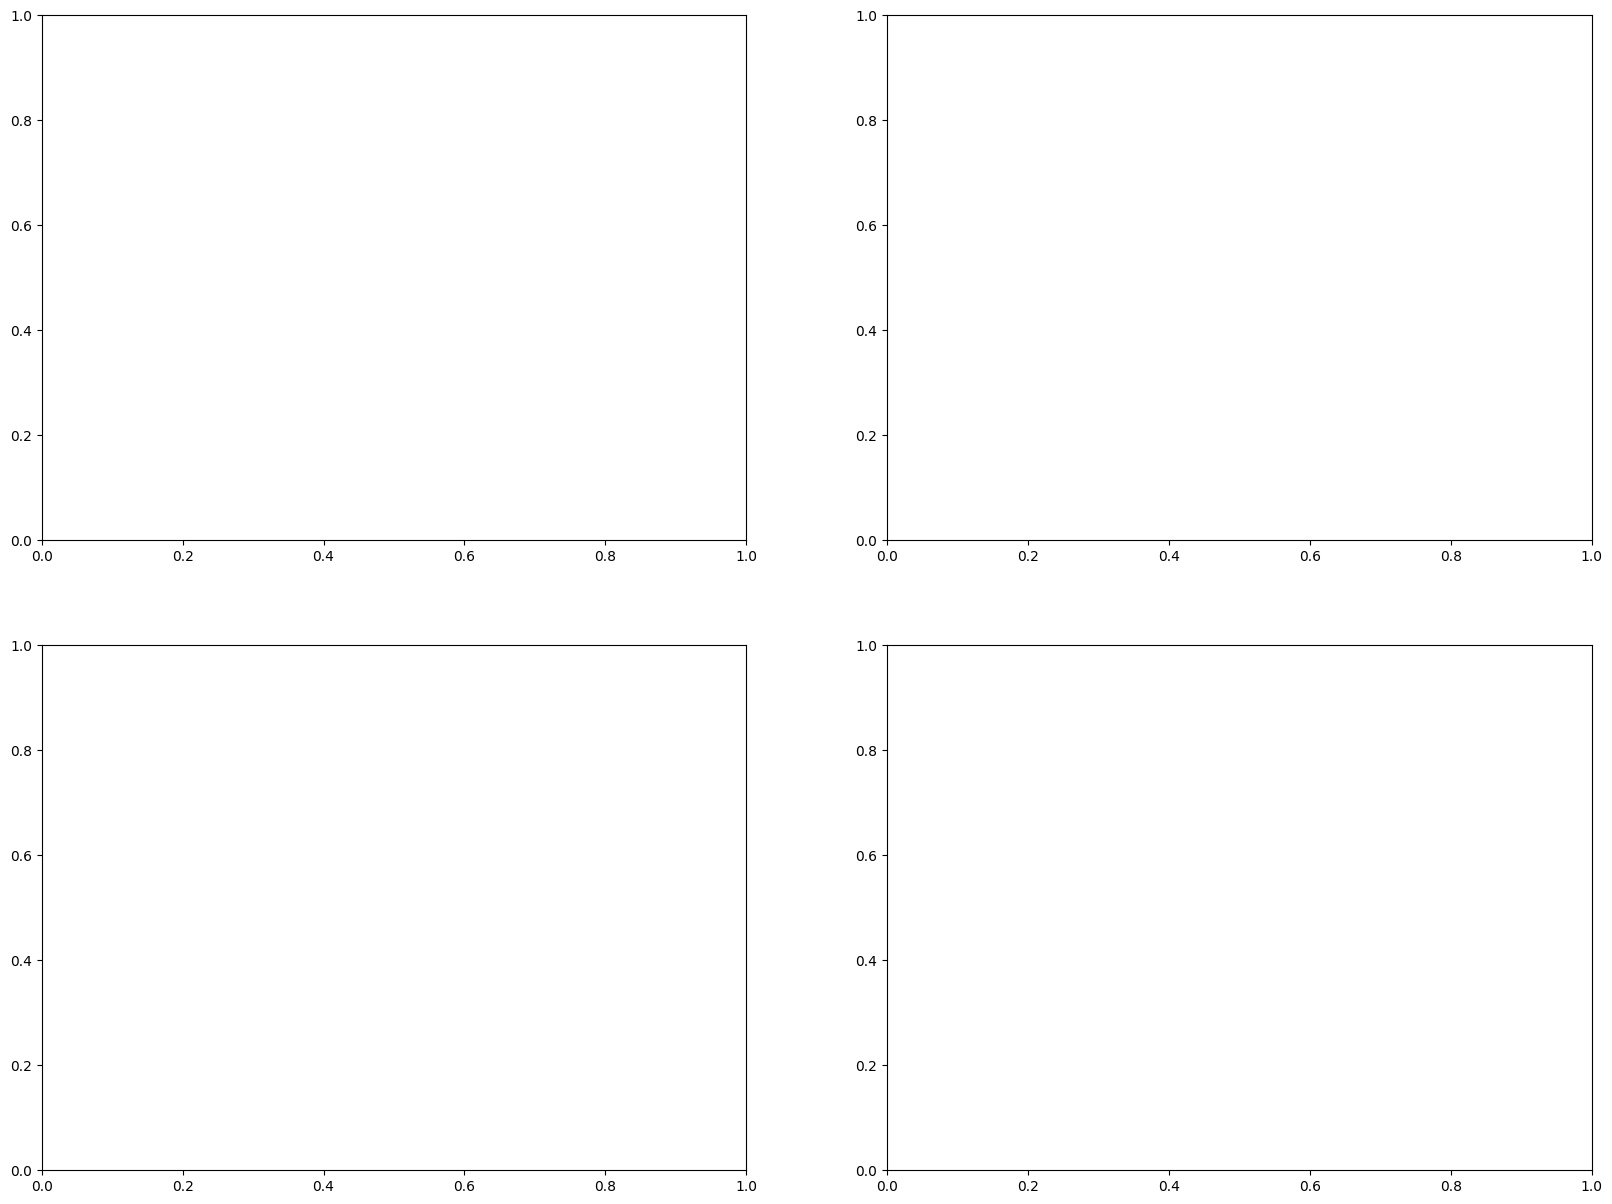

In [33]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(20, 15))



In [34]:
# Precision-Recall Curve
for i, (p, r) in enumerate(zip(metrics.box.p, metrics.box.r)):
    axs[0, 0].plot(r, p, label=f'Class {i}')
axs[0, 0].set_xlabel('Recall')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].set_title('Precision-Recall Curve')
axs[0, 0].legend()



In [ ]:
# Confusion Matrix
conf_matrix = metrics.confusion_matrix.matrix
axs[0, 1].imshow(conf_matrix, cmap='Blues')
axs[0, 1].set_title('Confusion Matrix')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('True')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axs[0, 1].text(j, i, f'{conf_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black")



## Testing Models

In [21]:
results = yolo_model('2.jpg')



image 1/1 /content/2.jpg: 640x480 1 class_0, 168.1ms
Speed: 3.2ms preprocess, 168.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


In [24]:
result = results[0]

boxes = result.boxes  # Bounding boxes
masks = result.masks  # Segmentation masks (if applicable)
probs = result.probs  # Classification probabilities (if applicable)


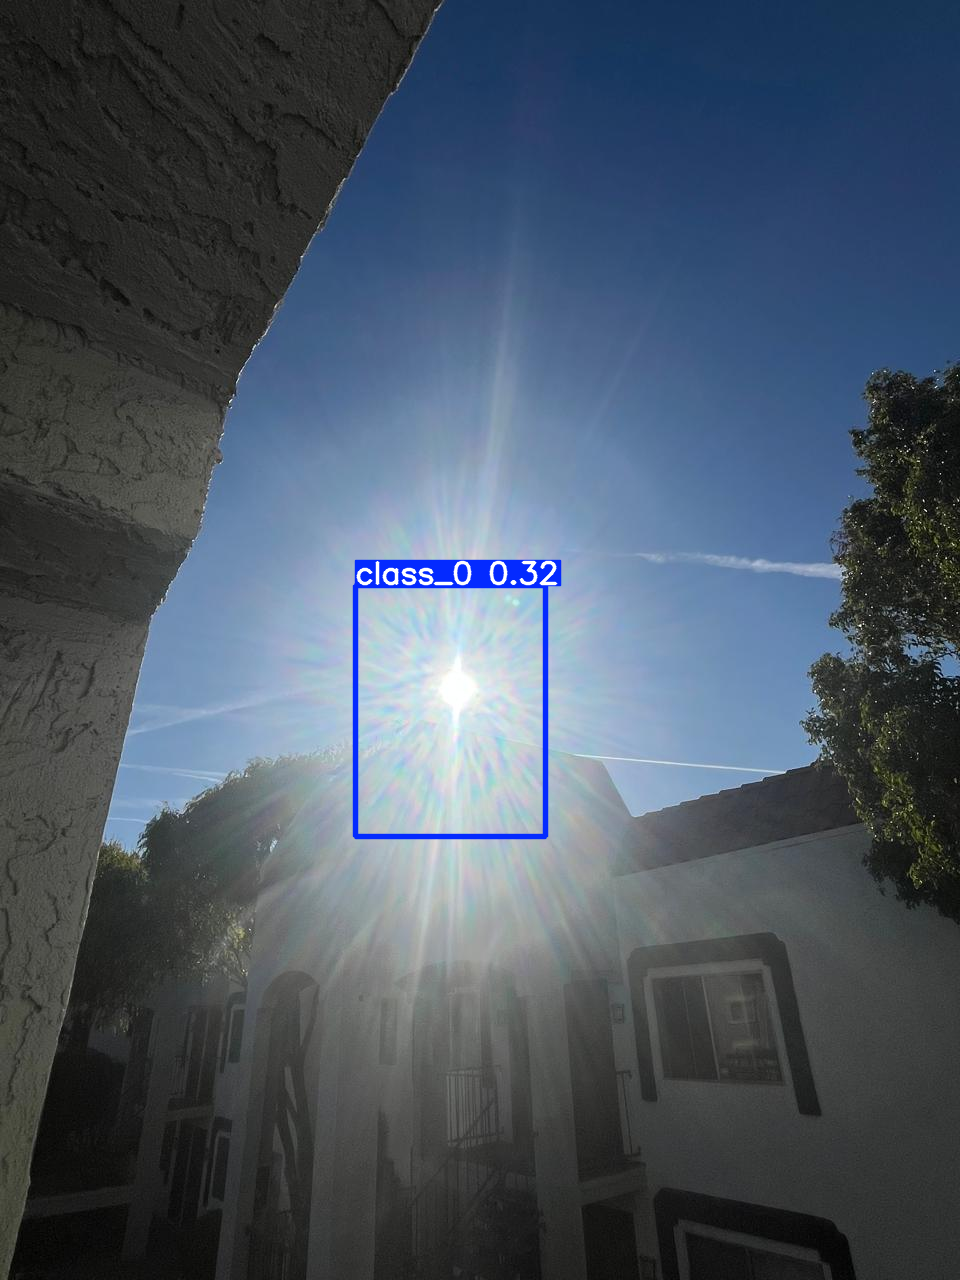

True

In [25]:
plot = result.plot()

cv2_imshow(plot)

cv2.imwrite("result_image.jpg", plot)


In [26]:
# Get bounding boxes
boxes = result.boxes.xyxy  # Get boxes in xyxy format
classes = result.boxes.cls  # Get class indices
conf = result.boxes.conf  # Get confidence scores

# Print detection details
for box, cls, cf in zip(boxes, classes, conf):
    print(f"Detected class: {cls.item()}, Confidence: {cf.item():.2f}")
    print(f"Bounding box: {box.tolist()}")


Detected class: 0.0, Confidence: 0.32
Bounding box: [355.13763427734375, 585.662353515625, 545.7974853515625, 836.3214111328125]


## Saving Model

In [27]:
yolo_model.save('drive/MyDrive/sun_tracker_model_2.pt')


## Pretrained Model Implementation

Static Models from roboflow web


| Model | mAP50-95 | Precision | Recall | Images | Type |
|-------|----------|-----------|--------|--------|------|
| Our YOLO model | 73.5% | 89.2% | 91.7% | 633 | YOLOv8 (custom trained) |
| solar-re1fe/1 | 96.8% | 95.2% | 94.3% | 2684 | Roboflow 3.0 Object Detection (Fast) |
| sun-tracking-photovoltaic-panel/1 | 98.2% | 93.7% | 93.7% | 196 | Roboflow 2.0 Object Detection (Fast) |
| sun-tracking/3 | 92.5% | 94.7% | 91.8% | 1090 | YOLOv5 Model Upload |
| sun-tracking-555mn/4 | 97.7% | 93.0% | 89.2% | 923 | YOLOv8n Model Upload |



1. **sun-tracking-555mn/4**
   - Best overall performance with 97.7% mAP
   - YOLOv8n architecture, which is lightweight and suitable for microcontrollers
   - Recently trained (2024-03-05)
   - Balanced dataset size (923 images)

2. **solar-re1fe/1**
   - High performance (96.8% mAP, 95.2% precision, 94.3% recall)
   - Largest dataset (2684 images), potentially good for generalization
   - Roboflow 3.0 Object Detection (Fast) may be suitable for microcontrollers

3. **sun-tracking-photovoltaic-panel/1**
   - Highest mAP (98.2%)
   - Roboflow 2.0 Object Detection (Fast) may work on microcontrollers
   - Limited dataset (196 images) might affect generalization

4. **sun-tracking/3**
   - Lowest mAP (92.5%) among the options
   - YOLOv5 architecture, which is generally suitable for microcontrollers
   - Decent dataset size (1090 images)


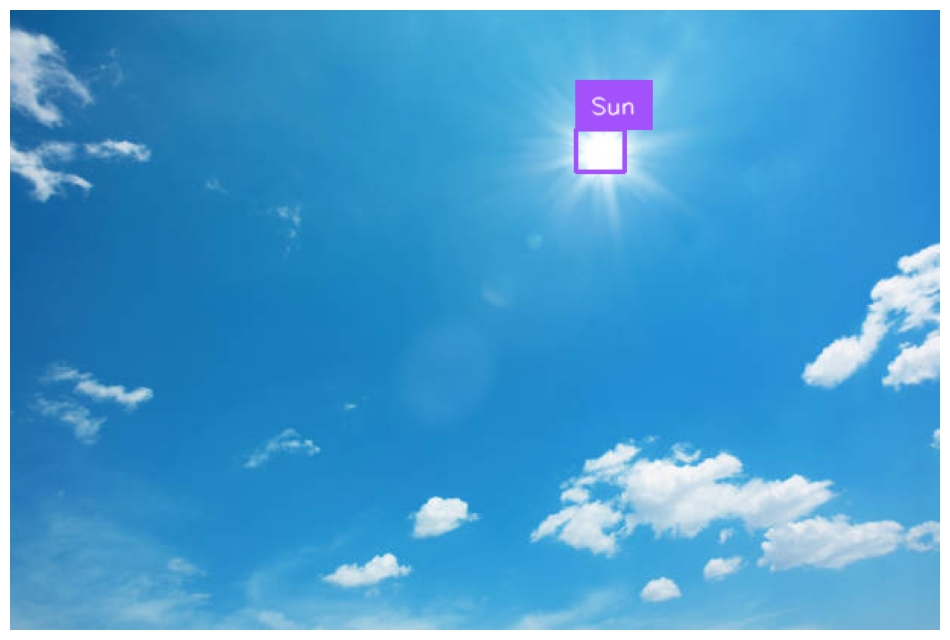

In [4]:


# define the image url to use for inference
image_file = "test/1.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
model = get_model(model_id="sun-tracking-555mn/4", api_key=api_key)

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

### Implementing Live Web Cam

#### Central Grid Vision

A central gride box which would determine the strongest position for the solar panel to position for maximum sunlight. The solar panel will follow and turn according to the distance between the central grid and the sun detected in camera

![image-1.png](https://github.com/somwrks/AI-Solar-Panel/blob/main/image-1.png?raw=true)

In [ ]:
def draw_central_box(frame, box_size=100):
    height, width = frame.shape[:2]
    center_x, center_y = width // 2, height // 2
    top_left = (center_x - box_size // 2, center_y - box_size // 2)
    bottom_right = (center_x + box_size // 2, center_y + box_size // 2)
    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
    return top_left, bottom_right

def calculate_distance_to_box(sun_center, top_left, bottom_right):
    sun_x, sun_y = sun_center
    box_x_min, box_y_min = top_left
    box_x_max, box_y_max = bottom_right

    closest_x = max(box_x_min, min(sun_x, box_x_max))
    closest_y = max(box_y_min, min(sun_y, box_y_max))

    return sun_x - closest_x, sun_y - closest_y


Applying different image filters for detecting sun in various environments

In [ ]:
def apply_sun_filter(frame):
    # Convert to float32 for better precision in calculations
    img = cv2.convertScaleAbs(frame, alpha=1.2)

    # Convert to HSV for better control
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    #  contrast enhancement
    hsv[:,:,2] = cv2.convertScaleAbs(hsv[:,:,2], alpha=-0.40)


    # # Convert back to BGR
    filtered = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return filtered

Adding Sun's position to adjust detection frequency based on sun movement to optimize power usage


In [ ]:
def calculate_sun_movement(lat, lon, time1, time2):
    pos1 = get_position(time1, lat, lon)
    pos2 = get_position(time2, lat, lon)
    movement = math.sqrt((pos2['azimuth'] - pos1['azimuth'])**2 + (pos2['altitude'] - pos1['altitude'])**2)
    return math.degrees(movement)

def calculate_detection_interval(lat, lon, current_time):
    future_time = current_time + timedelta(minutes=5)
    movement = calculate_sun_movement(lat, lon, current_time, future_time)  # Check movement over 5 minutes
    if movement > 1:  # If sun moves more than 1 degree in 5 minutes
        return 60  # Check every minute
    elif movement > 0.5:  # If sun moves more than 0.5 degrees in 5 minutes
        return 180  # Check every 3 minutes
    else:
        return 300  # Check every 5 minutes


Activating the camera only when needed for detection to conserve energy.


In [ ]:
def turn_off_camera(cap):
    cap.release()
    print("Camera turned off.")

def turn_on_camera():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Failed to turn on the camera.")
    else:
        print("Camera turned on.")
    return cap

### Setting up pipeline

In [ ]:
# Load the pre-trained model
model = get_model(model_id="sun-tracking-555mn/4", api_key=api_key)

# Create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Get current location
g = geocoder.ip('me')
latitude, longitude = g.latlng

print(f"Current location: {g.city}, {g.state}, {g.country}")
print(f"Latitude: {latitude}, Longitude: {longitude}")

# Initial sun detection
sun_detected = False
cap = turn_on_camera()

while not sun_detected and cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    filtered_frame = apply_sun_filter(frame)
    top_left, bottom_right = draw_central_box(filtered_frame)
    results = model.infer(filtered_frame)[0]
    detections = sv.Detections.from_inference(results)

    if len(detections) > 0:
        sun_detected = True
        for bbox in detections.xyxy:
            sun_center = ((bbox[0] + bbox[2])//2, (bbox[1] + bbox[3])//2)
            dx, dy = calculate_distance_to_box(sun_center, top_left, bottom_right)
            print(f"Initial Sun Detection - Time: {time.strftime('%H:%M:%S')}, dx: {dx}, dy: {dy}")
    else:
        print("Searching for sun...")

    annotated_frame = bounding_box_annotator.annotate(scene=filtered_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)
    cv2.imshow("Initial Sun Detection", annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

turn_off_camera(cap)

if sun_detected:
    print("Sun detected. Starting interval-based tracking.")
    detection_interval = calculate_detection_interval(latitude, longitude, datetime.now(timezone.utc))
    last_detection_time = time.time()

    while True:
        current_time = time.time()

        if current_time - last_detection_time >= detection_interval:
            cap = turn_on_camera()
            if cap.isOpened():
                ret, frame = cap.read()
                if ret:
                    filtered_frame = apply_sun_filter(frame)
                    top_left, bottom_right = draw_central_box(filtered_frame)
                    results = model.infer(filtered_frame)[0]
                    detections = sv.Detections.from_inference(results)

                    if len(detections) > 0:
                        for bbox in detections.xyxy:
                            sun_center = ((bbox[0] + bbox[2])//2, (bbox[1] + bbox[3])//2)
                            dx, dy = calculate_distance_to_box(sun_center, top_left, bottom_right)
                            print(f"Time: {time.strftime('%H:%M:%S')}, dx: {dx}, dy: {dy}")

                            detection_interval = calculate_detection_interval(latitude, longitude, datetime.now(timezone.utc))
                    else:
                        print("Sun not detected")

                    annotated_frame = bounding_box_annotator.annotate(scene=filtered_frame, detections=detections)
                    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)
                    cv2.imshow("Filtered Detection", annotated_frame)

                turn_off_camera(cap)

            last_detection_time = current_time

        time.sleep(1)  # Sleep for 1 second to reduce CPU usage

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()